# Create the networks - Whatsapp Use Case

This notebook can be used to guide the extraction of the backbones from our raw data. As some methods rely on proprietary tools, we have included also the outcome of this notebook (i.e., the obtained backbones) in the public repository

In [1]:
%load_ext autoreload
%autoreload 2
from dateutil import rrule
from datetime import date, datetime, timedelta
import pandas as pd
import pickle as pkl
import random
import matplotlib.pyplot as plt
import fastplot
import seaborn as sns
import scipy
import numpy as np
import itertools
import networkx as nx
from multiprocessing import Pool
from tqdm import tqdm
from tqdm.notebook import trange, tqdm

## Download and uncompress the dataset

In [ ]:
!mkdir -p WhatsApp && curl "https://mplanestore.polito.it/backbone_extraction/WhatsApp.tar.gz" --output - | tar -zxvf - 

## Create the networks using multiple backbone extraction algos

### Disparity Filter

In [ ]:
PATH_Networks = 'WhatsApp/networks/'
PATH_Backbones = 'WhatsApp/backbones/df/' 
list_snapshots = ['October']

# Please use and cite the code available for Michele Coscia in:
# Coscia, Michele, and Frank MH Neffke. "Network backboning with noisy data." 
# 2017 IEEE 33rd International Conference on Data Engineering (ICDE). IEEE, 2017.
# Download link: https://www.michelecoscia.com/?page_id=287

for snap in list_snapshots:
    nc_table = pd.read_csv(PATH_Networks+str(snap)+'.edgelist', delimiter=' ', names =['src', 'trg', 'nij', 'src_n', 'trg_n'])
    nc_table = utils.disparity_filter(nc_table)
    nc_table.to_csv(PATH_Backbones+str(snap)+'.edgelist', index=False, header=False)

### Polya Urn

In [ ]:
## Needs to be run on Matlab - See script in folder Polya
### Here we just filter the edges according to a p-value

In [ ]:
import pandas as pd
from os import getcwd
PATH_Networks = 'WhatsApp/networks/'
PATH_Backbones = 'WhatsApp/backbones/polya/'


# Please use and cite the code available for Michele Coscia in:
#Marcaccioli, Riccardo, and Giacomo Livan.
#"A pólya urn approach to information filtering in complex networks."
#Nature communications 10.1 (2019): 1-10.
# Download link: https://www.mathworks.com/matlabcentral/fileexchange/69501-pf


list_snapshots = ['October']
for snap in list_snapshots:
    df = pd.read_csv(PATH_Backbones+str(snap)+".edgelist", sep=' ', names=['src', 'trg' ,'w' ,'p'])
    test = df[df['p'] < 0.05]
    print(len(df), len(test))

### Naive Threshold

In [ ]:
import pandas as pd
from os import getcwd
PATH_Networks = 'WhatsApp/networks/'
PATH_Backbones = 'WhatsApp/backbones/threshold/'
list_snapshots = ['October']
threshold = 95
for snap in list_snapshots:
    df = pd.read_csv(PATH_Networks+str(snap)+".edgelist", sep=' ', names=['src', 'trg' ,'w'])
    value = np.percentile(df['w'], threshold)
    df[df['w'] > value]

### HSS

In [7]:
PATH_Networks = 'WhatsApp/networks/'
PATH_Backbones = 'WhatsApp/backbones/hss/' 
list_snapshots = ['October']

# Please use and cite the code available for Michele Coscia in:
# Coscia, Michele, and Frank MH Neffke. "Network backboning with noisy data." 
# 2017 IEEE 33rd International Conference on Data Engineering (ICDE). IEEE, 2017.
# Download link: https://www.michelecoscia.com/?page_id=287

for snap in list_snapshots:
    table = pd.read_csv(PATH_Networks+str(snap)+'.edgelist', delimiter=' ', names =['src', 'trg', 'nij', 'src_n', 'trg_n'])
    table = utils.high_salience_skeleton(table)
    table.to_csv(PATH_Backbones+str(snap)+'.edgelist', index=False, header=False)

Calculating HSS score...


In [9]:
import pandas as pd
PATH_Networks = 'WhatsApp/networks/'
PATH_Backbones = 'WhatsApp/backbones/hss/' 
snap = 'October'
table = pd.read_csv(PATH_Backbones+str(snap)+'.edgelist',names =['src', 'trg', 'nij', 'score'])

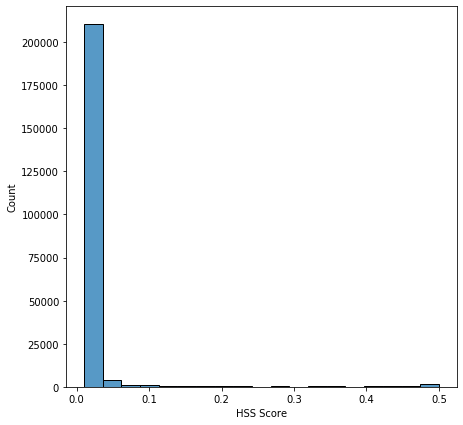

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
table['HSS Score'] = table['score'].round(2)
f, ax = plt.subplots(figsize=(7, 7))
sns.histplot(data=table, x="HSS Score")
#ax.set(yscale="log")
plt.savefig('WhatsApp/backbones/hss/dist_hss_scores.pdf')

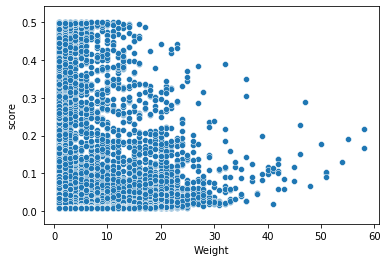

In [16]:
table['Weight'] = table['nij']
sns.scatterplot(data=table, x="Weight", y="score")
plt.savefig('WhatsApp/backbones/hss/scatter_hss_scores.pdf')

<Figure size 640x480 with 0 Axes>

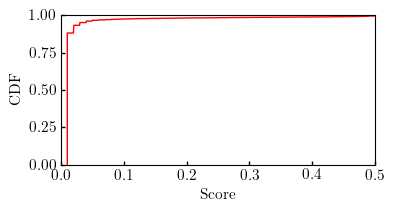

In [17]:
import fastplot
plot = fastplot.plot(table['HSS Score'], None, mode='CDF',
              xlabel = 'Score', style='latex')
plot.savefig('WhatsApp/backbones/hss/cdf_hss_score.pdf')
plot.show()

### RECAST

In [1]:
#Just generate the trace to be runned in JAVA
#See the oficial website to see how to run it

# Please use and cite the code available for Michele Coscia in:
# De Melo, Pedro OS Vaz, et al. 
# "Recast: Telling apart social and random relationships in dynamic networks." 
# Performance Evaluation 87 (2015): 19-36.
# Download Link: https://github.com/lab-csx-ufmg/RECAST/tree/master/RECAST

In [ ]:
def get_stats(df):
    global set_edges_to_remove
    global dict_media2_timestamp
    df = df.sort_values(by = "Timestamp")
    df = df.reset_index(drop=True)
    out_data = list()
    for t_i in df.itertuples():
        for t_j in df.itertuples(): 
            if t_i[0] < t_j[0]:
                if ((t_i[4], t_j[4]) not in set_edges_to_remove) and ((t_j[4], t_i[4]) not in set_edges_to_remove):
                    if t_i[4] != t_j[4] and t_i[5] ==  t_j[5]: 
                        if t_i[4] < t_j[4]:
                            entry = {"u": t_i[4], "v": t_j[4], "time_start": int(dict_media2_timestamp[str(t_i[5])].timestamp()), 
                                     "time_end": int(dict_media2_timestamp[str(t_i[5])].timestamp()+1)}
                        else:
                            entry = {"u": t_j[4], "v": t_i[4], "time_start": int(dict_media2_timestamp[str(t_i[5])].timestamp()), 
                                     "time_end": int(dict_media2_timestamp[str(t_i[5])].timestamp()+1)}
                                
                        out_data.append(entry)
    return pd.DataFrame(out_data)

def generate_trace(df):
    trace = df.groupby("Media_ID").apply(get_stats).reset_index(drop=True)
    trace['u'] = trace['u'].astype(int)
    trace['v'] = trace['v'].astype(int)
    trace['time_start'] = trace['time_start'].astype(int)
    trace['time_end'] = trace['time_end'].astype(int)
    return trace


PATH_RESULT = 'RECAST/RECAST/traces/whatsapp/'
df = pd.read_csv('WhatsApp/data/whatsapp_messages.csv', sep=',', names=['Timestamp', 'Week_Id', 
                                                                     'Group_ID', 'User_ID', 'Media_ID',
                                                                        'Media_Type', 'Misinformation'])

df = df[df['Week_Id'].isin([40, 41, 42, 43])]
df = df.reset_index(drop=True)

set_edges_to_remove = set() #First interaction no edges need to be disregarded
df["Timestamp"] = pd.to_datetime(df["Timestamp"], infer_datetime_format=True)

df_temp = df.sort_values(by=['Media_ID', 'Timestamp'])
df_temp = df_temp[['Media_ID', 'Timestamp']].drop_duplicates(subset=['Media_ID', 'Timestamp'], keep='first')
dict_media2_timestamp = dict(zip(df_temp['Media_ID'], df_temp['Timestamp']))

df = generate_trace(df)
temp = df.groupby(['u','v','time_start','time_end']).size().reset_index()
out_data = list()
for row in temp.itertuples():
    entry = {"u": row[1], "v": row[2], "time_start": row[3], "time_end": row[4]}
    while entry in out_data:
        entry['time_start'] +=1
        entry['time_end'] +=1
    out_data.append(entry)
df = pd.DataFrame(list(out_data))
df.sort_values(by='time_start', inplace=True)
limiar = min(df['time_start'])-1
df['time_start'] = df['time_start'] - limiar
df['time_end'] = df['time_end'] - limiar
df.to_csv(PATH_RESULT+'October-1.edgelist', sep=' ', index=False, header=False)

In [ ]:
df = pd.read_csv(PATH_RESULT+'October-1.edgelist',
                 names=['u','v','time_start','time_end'], sep=' ')

**After running RECAST in java, we need to create the edge list selecting just the two classes explicaned in the paper**

In [45]:
p_value = 0.05
df_map = pd.read_csv('RECAST/RECAST/traces/whatsapp/whatsapp-1_nodetable.dat', names=['map', 'id'], sep=' ')
dict_map = dict(zip(df_map['id'], df_map['map']))
del df_map
df = pd.read_csv('RECAST/RECAST/Graphs_Data/whatsapp-1/classified/classifiedwhatsapp-1_class0_threshold'+str(p_value)+'_time28', sep=' ', header=None)
df = df[df[9]<=2][[0,1]] ##Classes 1 and 2
df[0] = df[0].map(dict_map)
df[1] = df[1].map(dict_map)
tuple_edge_RECAST = set()
for u, v in zip(df[0], df[1]):
    if u < v:
        tuple_edge_RECAST.add((u,v))
    else:
        tuple_edge_RECAST.add((v,u))
index_recast = pd.MultiIndex.from_tuples(tuple_edge_RECAST, names=["u", "v"])
edge_list = pd.read_csv('WhatsApp/networks/October.edgelist', header=None, sep=' ', names=['u', 'v', 'w', 'u_n', 'v_n'])
edge_list = edge_list.set_index(['u', 'v'])
edge_list = edge_list.loc[index_recast].reset_index(drop=False)
print(edge_list.sort_values('w', ascending=False))
edge_list.to_csv('WhatsApp/backbones/recast/October-'+str(p_value)+'.edgelist', index=False, sep=' ')

        u     v   w  u_n   v_n
196   304  8586  58  196  3118
177   304  1229  58  196   696
295   304  6006  55  196  2232
299  1229  8602  54  696  3132
221   244  2458  51  156  1214
..    ...   ...  ..  ...   ...
195   304  6673   7  196  2486
137   593  1887   7  358  1008
51    304   694   7  196   417
46    304   499   7  196   313
245   947  6854   7  561  2557

[309 rows x 5 columns]
